# RNN을 이용한 문서 분류
## RNN(Recurrent Neural Networks)
- 순차 데이터나 시계열 데이터를 다루는 모형
- 입/출력을 시퀀스로 처리함 -> 단어의 순서를 고려하므로 문맥 파악에 좋음
- 활성화 함수: tanh(하이퍼볼릭 탄젠트)

<br/> <br/>
> 시계역 데이터: 일정 시간 간격으로 측정된 데이터 &nbsp; &nbsp; ex) 한 시간마다 측정한 기온 <br/>
&nbsp; &nbsp; 시계열 모형에서는 앞의 값들이 뒤의 값에 영향을 미친다고 가정함 <br/>
&nbsp; &nbsp; ex) t시점 온도 x(t) 예측을 위해 그 전 4시간의 온도 [x(t-4), x(t-3), x(t-2), x(t-1)] 를 입력으로 사용

<br/> <br/>
## [RNN vs Feed Forward](https://wikidocs.net/22886)
### RNN의 구조
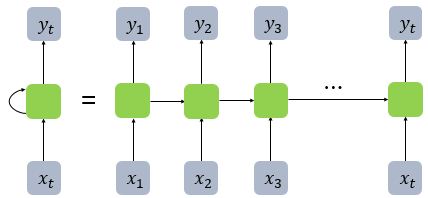
- x: 입력 벡터
- 초록색: 셀, 이전 값을 기억하는 일종의 메모리 역할, **다음 시점 t+1에 값을 보냄 -> 은닉 상태(hidden state)**
- y: 출력 벡터
> 수식 <br/>
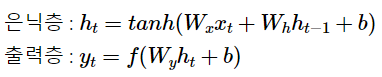

### 순방향 신경망(Feed Forward Nueral Network)
- 노드 간의 연결이 순환을 생성하지 않음
- 입력층 -> 은닉층 -> 출력층
- ex) CNN

<br/> <br/>

## RNN 유형
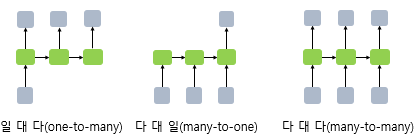
- 일대일(Fixsed size) ex) 이미지 분류
- 일대다(Sequence output) ex) 이미지 캡셔닝
- 다대일(Sequence input) ex) 감성분석 신경망
- 다대다(Sequence to sequence) ex) 기계번역

<br/> <br/>

## RNN 단점
**기울기 소실 문제(Gradient Vanishing)**: 입력층에 가까운 층들에서 기울기가 작아져 가중치가 제대로 업데이트 되지 않는 문제 <br/>
&nbsp; &nbsp; tanh를 활성화 함수로 사용해서 발생하는 문제 => 장기 의존성 문제 <br/>

이를 해결하기 위해 LSTM(Long Short-Term Memory)이 등장